## Load the data

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [26]:
df = pd.read_csv('listings_summary.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df.duplicated().sum()))

The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


In [27]:
columns_to_keep = ['neighbourhood_group_cleansed', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
                   'room_type', 'price', 'cleaning_fee', 'extra_people', 'security_deposit', 'minimum_nights']

df = df[columns_to_keep]
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df.shape))

The dataset has 22552 rows and 12 columns - after dropping irrelevant columns.


In [28]:
# For cleaning fee and security deposit, replace nulls with 0s.
df.cleaning_fee.fillna('$0.00', inplace=True)
df.security_deposit.fillna('$0.00', inplace=True)

### Drop NaNs and remove outliers

In [29]:
# drop the ~40 or so listings which don't include key info (bathrooms, bedrooms, beds)
df = df.dropna()

In [30]:
df.head()

,neighbourhood_group_cleansed,bathrooms,bedrooms,beds,bed_type,amenities,room_type,price,cleaning_fee,extra_people,security_deposit,minimum_nights
0,Mitte,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",Entire home/apt,$60.00,$30.00,$28.00,$200.00,4
1,Pankow,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",Private room,$17.00,$0.00,$0.00,$0.00,2
2,Pankow,1.0,1.0,2.0,Real Bed,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",Entire home/apt,$90.00,$50.00,$20.00,$200.00,62
3,Tempelhof - Schöneberg,1.0,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",Private room,$26.00,$30.00,$18.00,$250.00,5
4,Pankow,1.0,1.0,2.0,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",Private room,$42.00,$0.00,$24.00,$0.00,2


In [31]:
df = df.sort_values(by=['price'], ascending=False)

## Wrangle function for model 

In [34]:
# Effectively one-hot encoding by hand FOR THE MODEL 
df['Wifi'] = df['amenities'].str.contains('Wifi')
df['Kitchen'] = df['amenities'].str.contains('Kitchen')
df['Heating'] = df['amenities'].str.contains('Heating')
df['Essentials'] = df['amenities'].str.contains('Essentials')
df['Hair dryer'] = df['amenities'].str.contains('Hair dryer')
df['Laptop friendly workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['Hangers'] = df['amenities'].str.contains('Hangers')
df['Iron'] = df['amenities'].str.contains('Iron')
df['Shampoo'] = df['amenities'].str.contains('Shampoo')
df['TV'] = df['amenities'].str.contains('TV')
df['Hot water'] = df['amenities'].str.contains('Hot water')
df['Internet'] = df['amenities'].str.contains('Internet')
df['Host greets you'] = df['amenities'].str.contains('Host greets you')
df['Smoke detector'] = df['amenities'].str.contains('Smoke detector')
df['Buzzer/wireless intercom'] = df['amenities'].str.contains('Buzzer/wireless intercom')
df['Lock on bedroom door'] = df['amenities'].str.contains('Lock on bedroom door')
df['Buzzer/wireless intercom'] = df['amenities'].str.contains('Buzzer/wireless intercom')
df['Refrigerator'] = df['amenities'].str.contains('Refrigerator')
df['Free street parking'] = df['amenities'].str.contains('Free street parking')
df['Dishes and silverware'] = df['amenities'].str.contains('Dishes and silverware')
df = df.drop(columns=['amenities'])

In [35]:
# removing the dollar sign and comma, changing the type to float for price, cleaning_fee, and security_deposit
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [36]:
# Taking spaces out of the categorical features' data points
df.neighbourhood_group_cleansed = df.neighbourhood_group_cleansed.str.replace(' ', '')
df.bed_type = df.bed_type.str.replace(' ', '')
df.room_type = df.room_type.str.replace(' ', '')

In [42]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              random_state=42)

In [43]:
target = 'price'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = train.drop(columns=target)
y_val = train[target]

In [44]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [45]:
# Instantiate the model and encode categorical variables
rfmodel = make_pipeline(
    ce.OneHotEncoder(),
    RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
rfmodel.fit(X_train, y_train)
rf_pred = rfmodel.predict(X_val)

print('Validation Accuracy / R-Squared:', rfmodel.score(X_val, y_val)) 
print('Mean Absolute Error:', mean_absolute_error(y_val, rf_pred))
print('Mean Squared Error:', mean_squared_error(y_val, rf_pred))

Validation Accuracy / R-Squared: 0.9360610154232083
Mean Absolute Error: 10.662396935352527
Mean Squared Error: 3565.380252406006


In [46]:
encoder = rfmodel.named_steps['onehotencoder']
encoded = encoder.transform(X_train)

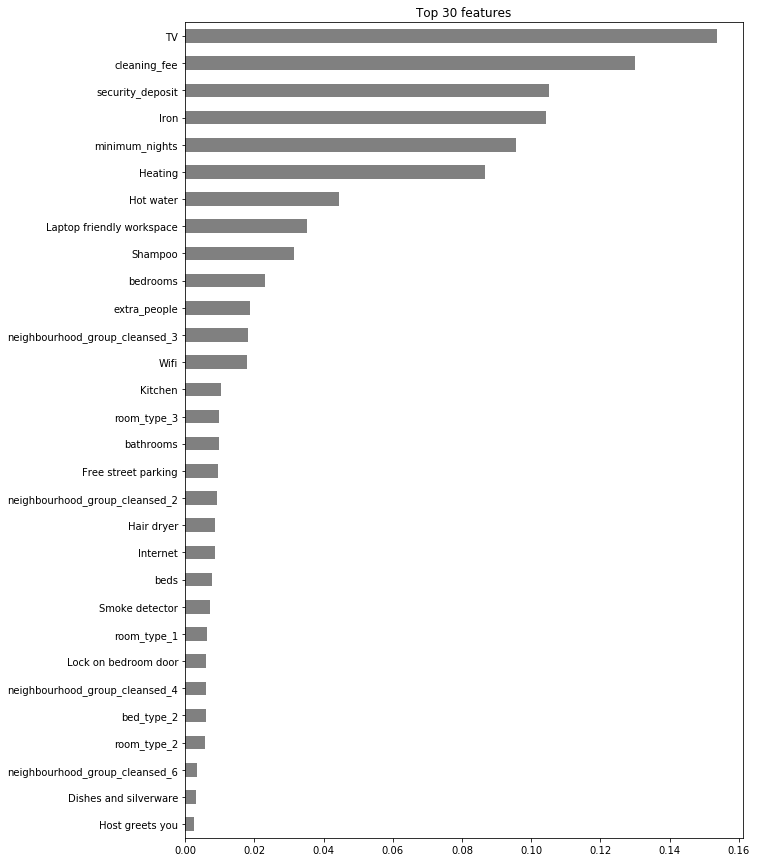

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = rfmodel.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot feature importances
n = 30
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='gray');

In [ ]:
import pickle
pickle.dump(rfmodel, open('model.pkl','wb'))

## Wrangle function for taking input data

In [ ]:
# Effectively one-hot encoding by hand FOR THE MODEL 
df['Wifi'] = df['amenities'].str.contains('Wifi')
df['Kitchen'] = df['amenities'].str.contains('Kitchen')
df['Heating'] = df['amenities'].str.contains('Heating')
df['Essentials'] = df['amenities'].str.contains('Essentials')
df['Hair dryer'] = df['amenities'].str.contains('Hairdryer')
df['Laptop friendly workspace'] = df['amenities'].str.contains('Laptopfriendlyworkspace')
df['Hangers'] = df['amenities'].str.contains('Hangers')
df['Iron'] = df['amenities'].str.contains('Iron')
df['Shampoo'] = df['amenities'].str.contains('Shampoo')
df['TV'] = df['amenities'].str.contains('TV')
df['Hot water'] = df['amenities'].str.contains('Hotwater')
df['Internet'] = df['amenities'].str.contains('Internet')
df['Host greets you'] = df['amenities'].str.contains('Hostgreetsyou')
df['Smoke detector'] = df['amenities'].str.contains('Smokedetector')
df['Buzzer/wireless intercom'] = df['amenities'].str.contains('Buzzer/wirelessintercom')
df['Lock on bedroom door'] = df['amenities'].str.contains('Lockonbedroomdoor')
df['Buzzer/wireless intercom'] = df['amenities'].str.contains('Buzzer/wirelessintercom')
df['Refrigerator'] = df['amenities'].str.contains('Refrigerator')
df['Free street parking'] = df['amenities'].str.contains('Freestreetparking')
df['Dishes and silverware'] = df['amenities'].str.contains('Dishesandsilverware')
df = df.drop(columns=['amenities'])